# Chapter 17: Practical statistical modeling

Note: The results may differ slightly between Python and R implementations, due to difference in random seeds as well as slight differences in data filtering between the two notebooks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, binom, scoreatpercentile, pearsonr, chi2
from scipy.spatial.distance import cdist
import pingouin as pg
import matplotlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from scipy.cluster import hierarchy
from scipy.special import logit
from sklearn.decomposition import PCA
import yellowbrick as yb
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

%matplotlib inline 
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

base = importr('lme4')
base = importr('tidyverse')
base = importr('broom')

%load_ext rpy2.ipython

rng = np.random.default_rng(1234567)

## Figure 17.1 Outliers and influential observations

<Figure size 800x800 with 0 Axes>

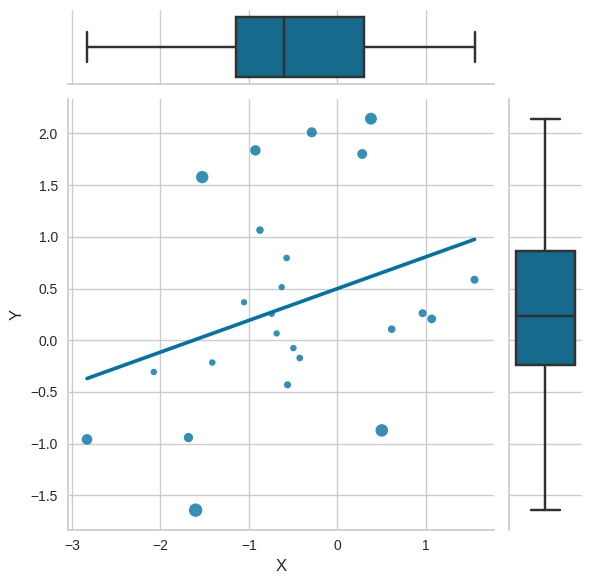

In [2]:
npts = 24
outlier_df = pd.DataFrame({'Y': rng.normal(size=npts)})
outlier_df['X'] = outlier_df.Y * 0.4 + rng.normal(size=npts)

def get_cooksD(X, Y):
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit() 
    influence = model.get_influence()
    return(influence.cooks_distance[0])

#sns.set_context("talk", font_scale=1.2)
plt.figure(figsize=(8,8))
g = sns.JointGrid(data=outlier_df, 
                  x="X",
                  y="Y")
g.plot_joint(sns.regplot, ci=None, scatter_kws={'s': 20 + get_cooksD(outlier_df.X, outlier_df.Y)*500})
g.plot_marginals(sns.boxplot)

## Figure 17.2: Collider bias

<Axes: xlabel='height', ylabel='speed'>

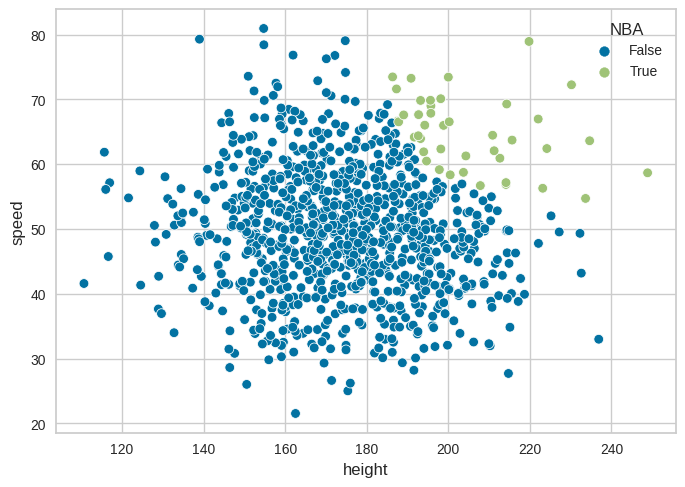

In [3]:
# https://observablehq.com/@herbps10/collider-bias
npts = 1000

conf_df = pd.DataFrame({'height': rng.normal(175, 20, npts),
                        'speed': rng.normal(50, 10, npts)})
conf_df['zheight'] = scale(conf_df.height)
conf_df['zspeed'] = scale(conf_df.speed)
conf_df['speedXheight'] = conf_df.zheight * conf_df.zspeed
conf_df['NBA'] = (conf_df.speedXheight > scoreatpercentile(conf_df.speedXheight, 90)) & \
    (conf_df.speed > conf_df.speed.mean()) & (conf_df.height > conf_df.height.mean())

sns.scatterplot(data=conf_df, x='height', y='speed', hue='NBA')

In [4]:
print(smf.ols(formula='speed ~ 1 + height', data=conf_df).fit().summary())


                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.122
Date:                Tue, 21 Feb 2023   Prob (F-statistic):              0.290
Time:                        15:11:51   Log-Likelihood:                -3693.9
No. Observations:                1000   AIC:                             7392.
Df Residuals:                     998   BIC:                             7402.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.8286      2.667     19.811      0.0

Model with NBA player status (collider)

In [5]:
print(smf.ols(formula='speed ~ 1 + height + NBA', data=conf_df).fit().summary())


                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     68.71
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           1.11e-28
Time:                        15:11:51   Log-Likelihood:                -3629.9
No. Observations:                1000   AIC:                             7266.
Df Residuals:                     997   BIC:                             7281.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      61.3954      2.608     23.541      

same regression only on the NBA players, where we see a strong negative relationship between speed and height:

In [6]:
print(smf.ols(formula='speed ~ 1 + height', data=conf_df.query('NBA == True')).fit().summary())


                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     5.261
Date:                Tue, 21 Feb 2023   Prob (F-statistic):             0.0271
Time:                        15:11:51   Log-Likelihood:                -128.55
No. Observations:                  42   AIC:                             261.1
Df Residuals:                      40   BIC:                             264.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     90.6515     11.265      8.047      0.0

## Example 1: Self-regulation and arrest

In [7]:
behavdata = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/Eisenberg/meaningful_variables.csv')
behavdata.set_index('subcode', inplace=True)
demoghealthdata = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/Eisenberg/demographic_health.csv')
demoghealthdata.set_index('subcode', inplace=True)
sexdict = {1:'Female', 0:'Male'}
demoghealthdata['Sex'] = [sexdict[i] for i in demoghealthdata['Sex']]
alldata = demoghealthdata.join(behavdata, how='inner')

rename_dict = {
    'upps_impulsivity_survey': 'UPPS',
    'sensation_seeking_survey': 'SSS',
    'dickman_survey': 'Dickman', 
    'bis11_survey': 'BIS11'
}

impulsivity_vars = []
for column in alldata.columns:
    for k, v in rename_dict.items():
        if k in column:
            alldata.rename(columns={column: column.replace(k, v)}, inplace=True)
            impulsivity_vars.append(column.replace(k, v))



## Table 17.1

Frequency distribution of number of reported arrests in the Eisenberg et al. dataset

In [21]:
arrestdata = alldata.dropna(subset=['ArrestedChargedLifeCount'])
arrestdata.loc['everArrested'] = arrestdata.ArrestedChargedLifeCount > 0

pd.DataFrame({
    'number': arrestdata.ArrestedChargedLifeCount.value_counts(),
    'proportion': arrestdata.ArrestedChargedLifeCount.value_counts()/arrestdata.shape[0]})


,number,proportion
0.0,409,0.783525
1.0,58,0.111111
2.0,33,0.063218
3.0,9,0.017241
5.0,5,0.009579
4.0,5,0.009579
6.0,2,0.003831


## Figure 17.3

/tmp/ipykernel_92/2323405881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impulsivity_data['everArrested'] = impulsivity_data.ArrestedChargedLifeCount > 0


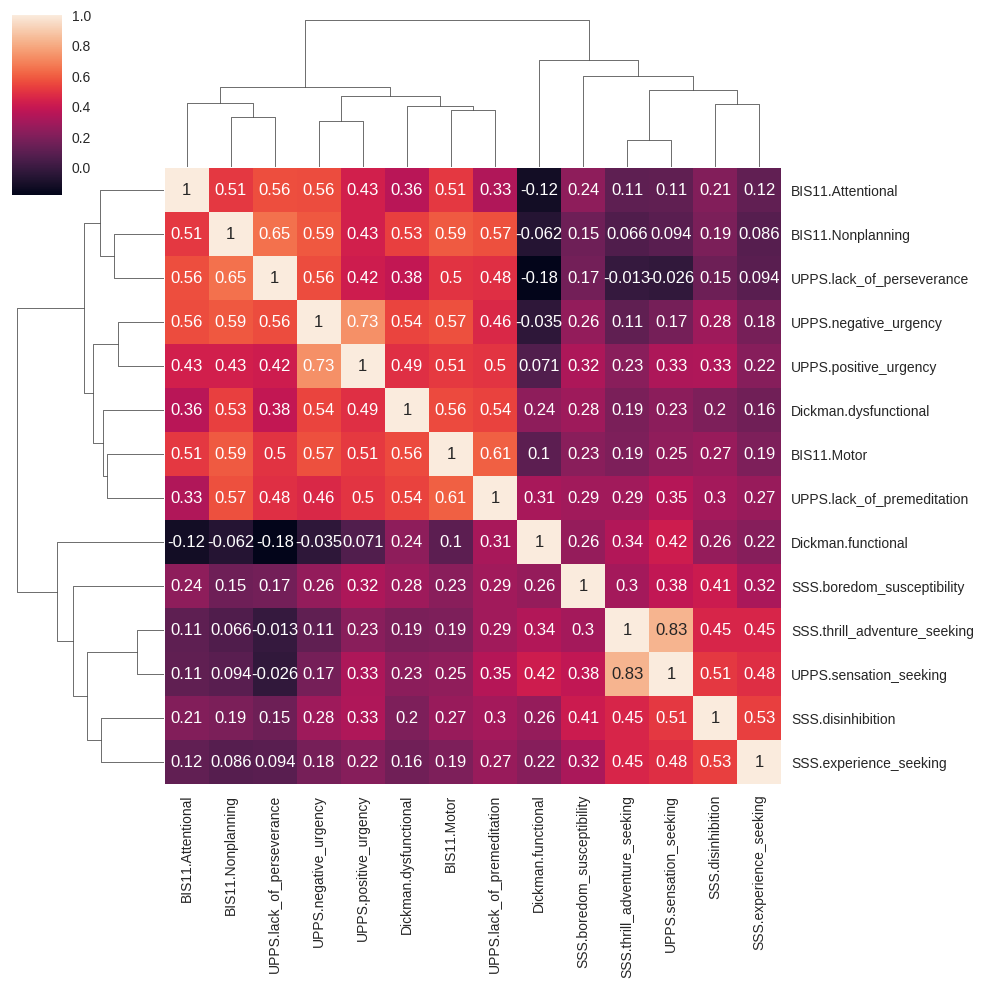

In [23]:

impulsivity_data = alldata.dropna(subset=['ArrestedChargedLifeCount', 
           'TrafficTicketsLastYearCount', 
           'TrafficAccidentsLifeCount', 'Age','Sex'])
impulsivity_data['everArrested'] = impulsivity_data.ArrestedChargedLifeCount > 0
cc = impulsivity_data[impulsivity_vars].corr()

sns.clustermap(cc, method='average', annot=True)

## Figure 17.4

/tmp/ipykernel_92/221161768.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impulsivity_data[k] = scale(v)
/tmp/ipykernel_92/221161768.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impulsivity_data[k] = scale(v)


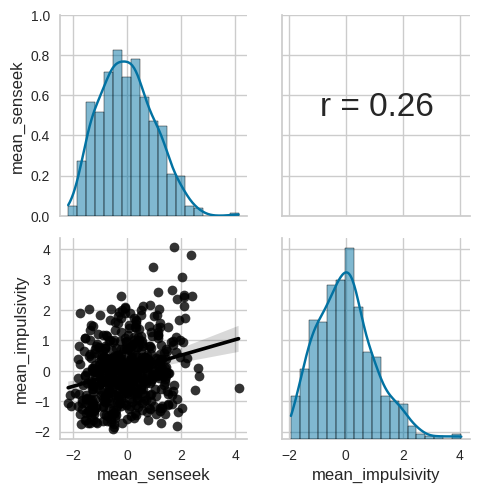

In [24]:
cls = AgglomerativeClustering(n_clusters=2)
cls.fit(cc)
# 0 is sensation seeking, 1 is impulsivity
varnames = ['mean_senseek', 'mean_impulsivity']
newvars = {}

for cluster in range(2):
    vars = [impulsivity_vars[i] for i in range(len(impulsivity_vars)) if cls.labels_[i] == cluster]
    newvars[varnames[cluster]] = impulsivity_data.loc[:, vars].mean(axis=1, skipna=True)

for k, v, in newvars.items():
    impulsivity_data[k] = scale(v)


g = sns.PairGrid(impulsivity_data[varnames])

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.2, .5), size=24, xycoords=ax.transAxes)

g.map_upper(corrfunc)
g.map_lower(sns.regplot, color='black')
g.map_diag(sns.histplot, kde=True, legend=False)
plt.show()


## Figure 17.5

<Axes: xlabel='everArrested', ylabel='mean_senseek'>

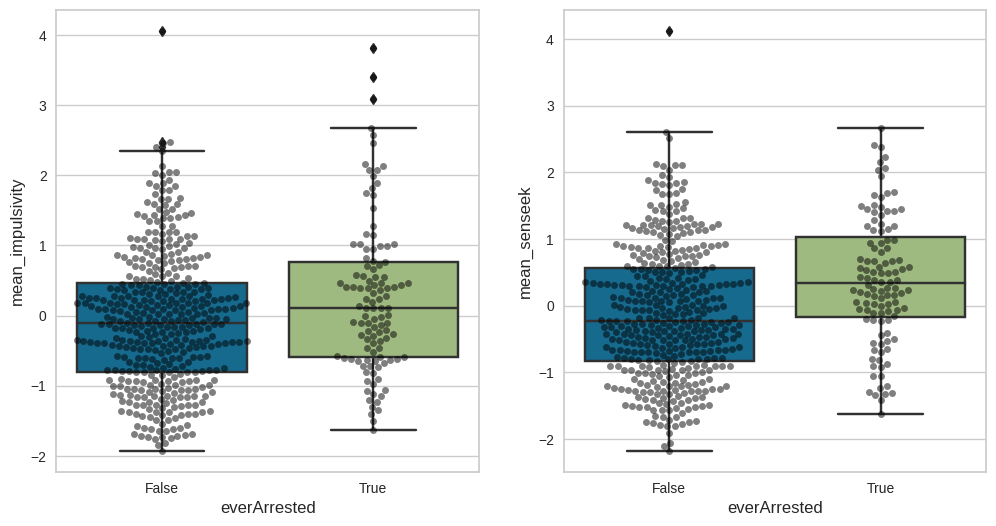

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.boxplot(data=impulsivity_data, x='everArrested', y='mean_impulsivity', ax=ax[0])
sns.swarmplot(data=impulsivity_data, x='everArrested', y='mean_impulsivity', ax=ax[0], color='black', alpha=0.5)

sns.boxplot(data=impulsivity_data, x='everArrested', y='mean_senseek', ax=ax[1])
sns.swarmplot(data=impulsivity_data, x='everArrested', y='mean_senseek', ax=ax[1], color='black', alpha=0.5)


 t-test output for the mean impulsivity scores:

In [12]:
tt = pg.ttest(x=impulsivity_data.query('everArrested == True').mean_impulsivity, 
              y=impulsivity_data.query('everArrested == False').mean_impulsivity,
              alternative='greater')
tt

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.910521,160.928447,greater,0.00206,"[0.14, inf]",0.334129,13.485,0.931108


t-test output for the sensation seeking variable:

In [13]:
tt = pg.ttest(x=impulsivity_data.query('everArrested == True').mean_senseek,
              y=impulsivity_data.query('everArrested == False').mean_senseek,
              alternative='greater')
tt

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.769141,182.383008,greater,0.000002,"[0.32, inf]",0.496897,1.11e+04,0.998687


## Figure 17.6: Logistic regression



Optimization terminated successfully.
         Current function value: 0.533560
         Iterations 6


Text(0.5, 1.0, 'A: Logistic regression')

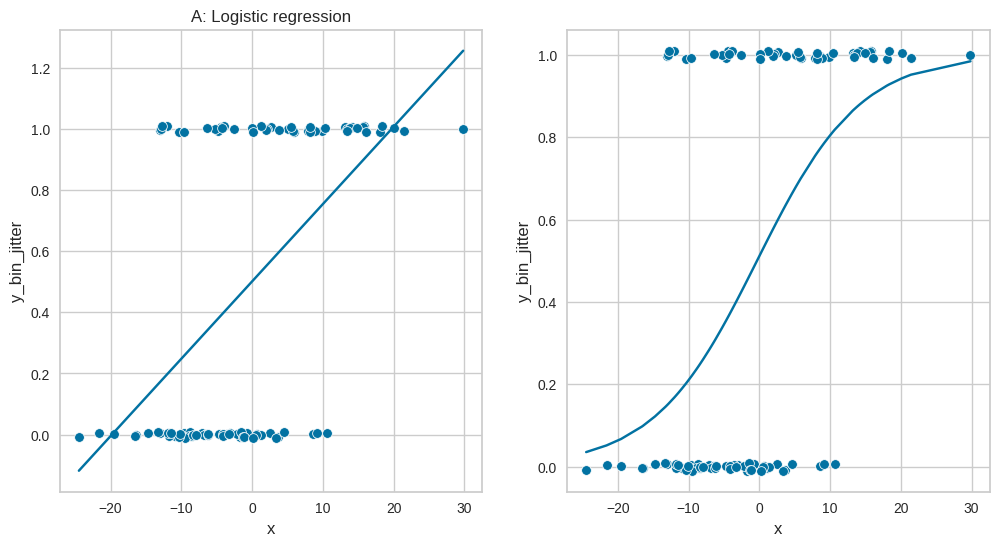

In [14]:
rng = np.random.default_rng(1234567)
n = 100
b0 = 100
b1 = 5

logreg_df = pd.DataFrame({'x': rng.normal(0, 10, n)})
logreg_df['y'] = b0 + b1 * logreg_df.x + rng.normal(0, 3, n)
logreg_df['y_bin'] =  (rng.uniform(size=n) < 1  /(1 + np.exp( -(logreg_df.y - logreg_df.y.mean()) / logreg_df.y.std()))).astype('int')
logreg_df['y_bin_jitter'] =  logreg_df.y_bin +  rng.uniform(-.01, .01, size=n)


lm = smf.ols(formula='y_bin ~ 1 + x', data=logreg_df)
lm_result = lm.fit()
logreg_df['lm_pred'] = lm_result.predict()

logistic = smf.logit(formula='y_bin ~ 1 + x', data=logreg_df)
logistic_result = logistic.fit()
logreg_df['logistic_pred'] = logistic_result.predict()



fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.scatterplot(data=logreg_df, x='x', y='y_bin_jitter', ax=ax[0])
sns.lineplot(data=logreg_df, x='x', y='lm_pred', ax=ax[0])
ax[0].set_title('A: Linear regression')

sns.scatterplot(data=logreg_df, x='x', y='y_bin_jitter', ax=ax[1]) 
sns.lineplot(data=logreg_df, x='x', y='logistic_pred', ax=ax[1])
ax[0].set_title('A: Logistic regression')

Logistic regression output:

In [15]:
print(logistic_result.summary())

                           Logit Regression Results                           
Dep. Variable:                  y_bin   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                  0.2300
Time:                        15:11:56   Log-Likelihood:                -53.356
converged:                       True   LL-Null:                       -69.295
Covariance Type:            nonrobust   LLR p-value:                 1.642e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0447      0.238      0.188      0.851      -0.422       0.512
x              0.1369      0.030      4.604      0.000       0.079       0.195


Logistic regression output for impulsivity dataset

In [26]:
impulsivity_data.loc[:, 'AgeSquared'] = (impulsivity_data.Age - impulsivity_data.Age.mean()) ** 2
impulsivity_data.loc[:, 'everArrestedInt'] = impulsivity_data.everArrested.astype('int')

# the following is for R 
impulsivity_data.loc[:, 'SexInt'] = [1 if i == 'Male' else 0 for i in impulsivity_data.Sex]
impulsivity_data = impulsivity_data[['everArrestedInt', 'mean_impulsivity', 'mean_senseek', 'Age', 'AgeSquared', 'Sex', 'SexInt']]

glm_imp_arrest = smf.glm(
    formula='everArrestedInt ~ 1 + mean_impulsivity + mean_senseek + Age +   Sex', 
    data=impulsivity_data,
    family=sm.families.Binomial())
logistic_result = glm_imp_arrest.fit()

print(logistic_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        everArrestedInt   No. Observations:                  521
Model:                            GLM   Df Residuals:                      516
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -250.58
Date:                Tue, 21 Feb 2023   Deviance:                       501.15
Time:                        15:16:59   Pearson chi2:                     532.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07599
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.3826      0.558  

/tmp/ipykernel_92/1360466332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impulsivity_data.loc[:, 'AgeSquared'] = (impulsivity_data.Age - impulsivity_data.Age.mean()) ** 2
/tmp/ipykernel_92/1360466332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impulsivity_data.loc[:, 'everArrestedInt'] = impulsivity_data.everArrested.astype('int')
/tmp/ipykernel_92/1360466332.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Compare with R results

In [28]:
%%R -i impulsivity_data

glm_imp_arrest = glm('everArrestedInt ~ 1 + mean_impulsivity + mean_senseek + Age +  SexInt', 
    data=impulsivity_data,
    family='binomial')

print(summary(glm_imp_arrest))



Call:
glm(formula = "everArrestedInt ~ 1 + mean_impulsivity + mean_senseek + Age +  SexInt", 
    family = "binomial", data = impulsivity_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3386  -0.7119  -0.5722  -0.3575   2.4726  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.38260    0.55767  -6.066 1.31e-09 ***
mean_impulsivity  0.28595    0.11309   2.528 0.011459 *  
mean_senseek      0.37779    0.11754   3.214 0.001308 ** 
Age               0.04849    0.01438   3.372 0.000746 ***
SexInt            0.65095    0.23793   2.736 0.006222 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 542.33  on 520  degrees of freedom
Residual deviance: 501.15  on 516  degrees of freedom
AIC: 511.15

Number of Fisher Scoring iterations: 4



#### Test for overdispersion

There is no built-in test for overdispersion in Python.  However, we can perform a simple chi-squared test for overdispersion, by dividing the Pearson chi-squared statistic by the residual degrees of freedom, which gives the same result as the R overdispersion test using the chi-squared.

In [29]:
chisq_stat = logistic_result.pearson_chi2 / logistic_result.df_resid
print('dispersion = ', chisq_stat)

pval = 1 - chi2.cdf(logistic_result.pearson_chi2, logistic_result.df_resid)
print('pvalue (alternative ="greater") = ', pval)


dispersion =  1.0305993193299552
pvalue (alternative ="greater") =  0.3059811971051235


Compare to R result

In [30]:
%%R

library('DHARMa')

print(testDispersion(glm_imp_arrest, alternative='greater', type='PearsonChisq'))

R[write to console]: This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')




	Parametric dispersion test via mean Pearson-chisq statistic

data:  glm_imp_arrest
dispersion = 1.0306, df = 516, p-value = 0.306
alternative hypothesis: greater



### Figure 17.7

In [31]:
# the statsmodels lowess smoother returned all zeros, so we are using this
# from https://xavierbourretsicotte.github.io/loess.html

from math import ceil
import numpy as np
from scipy import linalg

def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest


/tmp/ipykernel_92/3594777561.py:37: RuntimeWarning: divide by zero encountered in divide
  delta = np.clip(residuals / (6.0 * s), -1, 1)
/tmp/ipykernel_92/3594777561.py:37: RuntimeWarning: invalid value encountered in divide
  delta = np.clip(residuals / (6.0 * s), -1, 1)


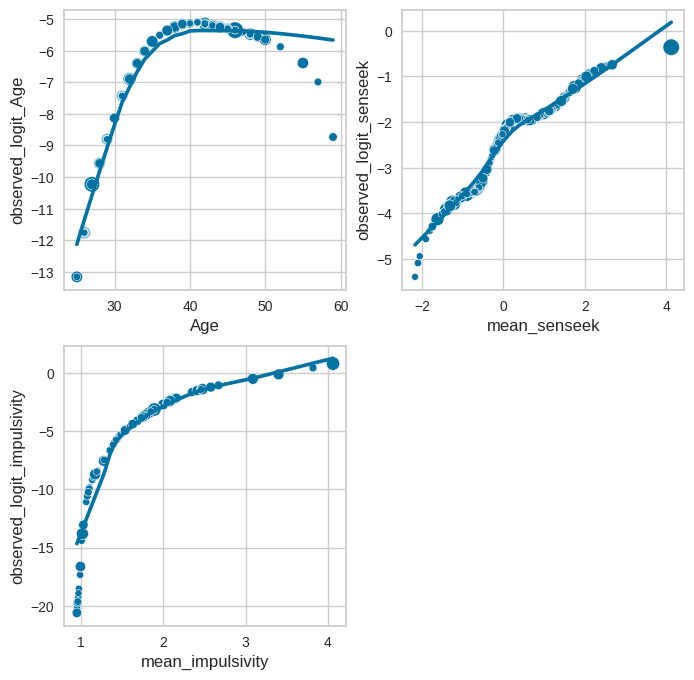

In [32]:
def cat_logit_est(iv, df, max_bins=18):
    ncats = np.min((max_bins, np.round(iv.unique().shape[0] / 2).astype('int')))
    iv_cut = pd.cut(iv, ncats)
    glm_imp_arrest = smf.glm(
        formula='everArrestedInt ~ 1 + iv_cut', data=df, 
        family=sm.families.Binomial())
    logistic_result = glm_imp_arrest.fit()
    # rint(logistic_result.summary())
    return(logistic_result.predict(linear=True))

def loess_logit_est(iv, df, frac=0.5):
    lowess = lowess_ag(iv.values, df.everArrestedInt.values, f=frac, )
    lowess[lowess<=0] = 0 #negatives can happen at edges
    logit_of_fit = logit(lowess)
    return(logit_of_fit)

# using loess as in R example

impulsivity_data['observed_logit_Age'] = loess_logit_est(impulsivity_data.Age, impulsivity_data)
impulsivity_data['observed_logit_senseek'] = loess_logit_est(impulsivity_data.mean_senseek, impulsivity_data)
impulsivity_data['observed_logit_impulsivity'] = loess_logit_est(impulsivity_data.mean_impulsivity, impulsivity_data)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

sns.scatterplot(data=impulsivity_data, x='Age', y='observed_logit_Age', ax=ax[0][0],
               s=25 + logistic_result.get_influence().cooks_distance[0]*5000)
sns.regplot(data=impulsivity_data, x='Age', y='observed_logit_Age', scatter=False, lowess=True,ax=ax[0][0])

sns.scatterplot(data=impulsivity_data, x='mean_senseek', y='observed_logit_senseek', ax=ax[0][1],
               s=25 + logistic_result.get_influence().cooks_distance[0]*5000)
sns.regplot(data=impulsivity_data, x='mean_senseek', y='observed_logit_senseek', scatter=False, lowess=True,ax=ax[0][1])

sns.scatterplot(data=impulsivity_data, x='mean_impulsivity', y='observed_logit_impulsivity', ax=ax[1][0],
               s=25 + logistic_result.get_influence().cooks_distance[0]*5000)
sns.regplot(data=impulsivity_data, x='mean_impulsivity', y='observed_logit_impulsivity', scatter=False, lowess=True,ax=ax[1][0])

ax[1][1].set_visible(False)

model including $Age^2$ alongside Age

In [33]:
glm_imp_arrest = smf.glm(
    formula='everArrestedInt ~ 1 + mean_impulsivity + mean_senseek + Age + AgeSquared +  Sex', 
    data=impulsivity_data,
    family=sm.families.Binomial())
logistic_result2 = glm_imp_arrest.fit()

print(logistic_result2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        everArrestedInt   No. Observations:                  521
Model:                            GLM   Df Residuals:                      515
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -247.72
Date:                Tue, 21 Feb 2023   Deviance:                       495.45
Time:                        15:18:08   Pearson chi2:                     536.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08605
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.9824      0.649  

### Table 17.2

In [34]:
params = pd.DataFrame(logistic_result2.params, columns=['estimate'])

params = params.join(logistic_result2.conf_int())

params = np.exp(params.rename(columns={0: '2.5%', 1: '97.5%'}).drop('Intercept'))

params

,estimate,2.5%,97.5%
Sex[T.Male],1.986540,1.245420,3.168685
mean_impulsivity,1.358978,1.086920,1.699134
mean_senseek,1.463696,1.161603,1.844354
Age,1.075341,1.036751,1.115367
AgeSquared,0.995775,0.992140,0.999424


Bayes factor using approximation via BIC

In [35]:
glm_imp_arrest_baseline = smf.glm(
    formula='everArrestedInt ~ 1 + Age + AgeSquared +  Sex', 
    data=impulsivity_data,
    family=sm.families.Binomial())
logistic_result_baseline = glm_imp_arrest_baseline.fit()


BF_01 = np.exp((logistic_result2.bic - logistic_result_baseline.bic)/2)  # BICs to Bayes factor

1/BF_01

/opt/conda/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1799: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


241.79055403580912

## Example 2: Mask-wearing and face-touching

### Figure 17.8

In [36]:
maskdata = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/mask_wearing/DataVersion2/MaskFaceTouchOSF.csv')
maskdata = maskdata.query('face_touching != "Missing"')
maskdata.face_touching = np.where(maskdata.face_touching == 'Yes', 1, 0)
maskdata.mask_front_touching = np.where(maskdata.mask_front_touching == 'Yes', 1, 0)
maskdata.mask_strap_touching = np.where(maskdata.mask_strap_touching == 'Yes', 1, 0)
maskdata['face_touching'] = np.clip(maskdata.face_touching + maskdata.mask_front_touching + maskdata.mask_strap_touching, None, 1)
maskdata['mask_wearing'] = np.where(maskdata.mask_YesNo == 'Yes', 1, 0)
maskdata['age_std'] = scale(maskdata.age)
maskdata['segment_crowding_std'] = scale(maskdata.segment_crowding)
maskdata = maskdata.query('change == 0 and non_covering != "Yes"')

maskdata_study1 = maskdata.query('study == 1')
maskdata_study2 = maskdata.query('study == 2')

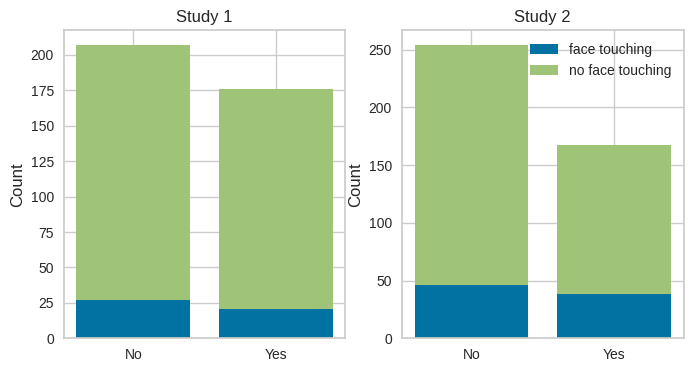

In [37]:
# there is no built-in stacked bar plot function in seaborn

fig, ax = plt.subplots(1, 2, figsize=(8,4))

study1_sums = maskdata_study1.groupby('mask_wearing')['face_touching'].value_counts()
study2_sums = maskdata_study2.groupby('mask_wearing')['face_touching'].value_counts()

labels = ['No', 'Yes']
ax[0].bar(labels, study1_sums.loc[:, 1], label='face touching')
ax[0].bar(labels, study1_sums.loc[:, 0], bottom=study1_sums.loc[:, 1], label='no face touching')

ax[1].bar(labels, study2_sums.loc[:, 1], label='face touching')
ax[1].bar(labels, study2_sums.loc[:, 0], bottom=study2_sums.loc[:, 1], label='no face touching')
ax[1].legend()

for i in range(2):
    ax[i].set_ylabel('Count')
    ax[i].set_title(f'Study {i + 1}')

plt.show()


simple chi-squared test

In [38]:
pg.chi2_independence(maskdata_study1, 'mask_wearing', 'face_touching')[2].loc[0, :]

test       pearson
lambda         1.0
chi2      0.029801
dof            1.0
pval      0.862943
cramer    0.008821
power     0.053421
Name: 0, dtype: object

analogous test for the data from the second study

In [39]:
pg.chi2_independence(maskdata_study2, 'mask_wearing', 'face_touching')[2].loc[0, :]

test       pearson
lambda         1.0
chi2      1.085429
dof            1.0
pval      0.297486
cramer    0.050776
power     0.180619
Name: 0, dtype: object

Logistic regression  model including duration and study along with mask wearing

In [40]:


glm_mask1 = smf.glm(
    formula='face_touching ~ mask_wearing + duration_of_observation + study', 
    data=maskdata,
    family=sm.families.Binomial())
logistic_result_mask1 = glm_mask1.fit()

print(logistic_result_mask1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          face_touching   No. Observations:                  804
Model:                            GLM   Df Residuals:                      800
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -342.50
Date:                Tue, 21 Feb 2023   Deviance:                       685.00
Time:                        15:18:37   Pearson chi2:                     806.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04025
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [41]:
# clean up maskdata for use within R

maskdata = maskdata[['face_touching', 'mask_wearing', 'duration_of_observation', 'study', 'unique_situation']]

In [42]:
%%R -i maskdata

glm_result_combined = glm(face_touching ~ mask_wearing + duration_of_observation + study,
                          family=binomial, data=maskdata)
print(summary(glm_result_combined))


Call:
glm(formula = face_touching ~ mask_wearing + duration_of_observation + 
    study, family = binomial, data = maskdata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7465  -0.6011  -0.5299  -0.4732   2.1918  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -3.342553   0.391507  -8.538  < 2e-16 ***
mask_wearing             0.191901   0.197742   0.970  0.33182    
duration_of_observation  0.028991   0.006182   4.689 2.74e-06 ***
study                    0.571684   0.200441   2.852  0.00434 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 718.03  on 803  degrees of freedom
Residual deviance: 685.00  on 800  degrees of freedom
AIC: 693

Number of Fisher Scoring iterations: 4



#### Mixed effects model

There is no exact replica of `glmer()` within Python.  The statsmodels package includes a function for estimating the parameters of a mixed effect logistic regression model using Bayesian estimation, which we show here for comparison.

In [43]:
random = {"a": '0 + C(unique_situation)', "b": '0 + C(unique_situation) * mask_wearing'}
glm_result = BinomialBayesMixedGLM.from_formula('face_touching ~ mask_wearing + duration_of_observation', random, maskdata)

fitted_glm_result = glm_result.fit_vb()
print(fitted_glm_result.summary())

                      Binomial Mixed GLM Results
                        Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
----------------------------------------------------------------------
Intercept                  M    -2.5007   0.0980                      
mask_wearing               M     0.1138   0.1473                      
duration_of_observation    M     0.0293   0.0032                      
a                          V    -1.0124   0.0624 0.363   0.321   0.412
b                          V    -1.5560   0.0441 0.211   0.193   0.230
Parameter types are mean structure (M) and variance structure (V)
Variance parameters are modeled as log standard deviations


/opt/conda/lib/python3.10/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")


This function doesn't give p-values, but we can compute the probability that each of the parameters is greater than zero, using the mean and standard deviation estimates.

In [44]:
p_mask_wearing = 1- norm.cdf(0, loc=-fitted_glm_result.fe_mean[1], scale=fitted_glm_result.fe_sd[1])
p_duration = 1 - norm.cdf(0, loc=-fitted_glm_result.fe_mean[2], scale=fitted_glm_result.fe_sd[2])

print('P(mask_wearing <= 0| data) =', p_mask_wearing)
print('P(duration <= 0| data) =', p_duration)

P(mask_wearing <= 0| data) = 0.2199304483248199
P(duration <= 0| data) = 0.0


Compute in R for comparison

In [45]:
%%R -i maskdata
library(lme4)
library(tidyverse)
glmer_result = glmer(face_touching ~ mask_wearing + duration_of_observation + (1 + mask_wearing  |unique_situation), data=maskdata, family=binomial)
glmer_result_baseline = update(glmer_result, formula = ~ . -mask_wearing)  # Without mask effect term

maskdata = maskdata %>%
  mutate(glmer_resid = residuals(glmer_result),
         )

print(summary(glmer_result))


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: face_touching ~ mask_wearing + duration_of_observation + (1 +  
    mask_wearing | unique_situation)
   Data: maskdata

     AIC      BIC   logLik deviance df.resid 
   704.2    732.4   -346.1    692.2      798 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6847 -0.4289 -0.3888 -0.3335  3.1095 

Random effects:
 Groups           Name         Variance Std.Dev. Corr 
 unique_situation (Intercept)  0.1829   0.4277        
                  mask_wearing 0.1599   0.3999   -0.40
Number of obs: 804, groups:  unique_situation, 129

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -2.518255   0.245319 -10.265  < 2e-16 ***
mask_wearing             0.145705   0.253822   0.574    0.566    
duration_of_observation  0.029691   0.006409   4.633 3.61e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.

test for overdispersion:

In [46]:
%%R

print(testDispersion(glmer_result, alternative='greater', type='PearsonChisq'))


	Parametric dispersion test via mean Pearson-chisq statistic

data:  glmer_result
dispersion = 0.92427, df = 798, p-value = 0.9377
alternative hypothesis: greater



### Figure 17.9

We do this in R since otherwise we would have to work with the glmer result in Python, which is difficult.

R[write to console]: 
Attaching package: ‘psych’


R[write to console]: The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




`geom_smooth()` using formula = 'y ~ x'


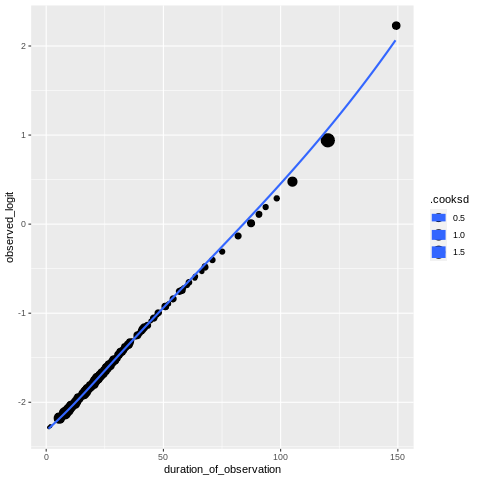

In [47]:
%%R

library(broom.mixed)
library(psych)
loess_logit_est2 = function(iv, span=1){
  fit = loess(face_touching_int ~ iv, data=maskmodeldata, span=span)$fitted
  fit[fit<=0] = 0 #negatives can happen at edges
  logit_of_fit = logit(fit)
  return(logit_of_fit)
}


maskmodeldata = augment(glmer_result) %>%
  mutate(face_touching_int = as.integer(face_touching))
maskmodeldata = maskmodeldata %>%
  mutate(observed_logit = loess_logit_est2(duration_of_observation))

ggplot(maskmodeldata, aes(duration_of_observation, observed_logit, size=.cooksd))+
  geom_jitter() +
  geom_smooth(method = "loess", se=FALSE)

### Table 17.3

here too we use R code

In [69]:
%%R

effect_table = tidy(glmer_result,conf.int=TRUE,exponentiate=TRUE,effects="fixed") %>%
  dplyr::select(term, estimate, conf.low, conf.high)

names(effect_table) = c('', 'Odds ratio', '2.5 %', '97.5 %')
effect_table[2:3,]

# A tibble: 2 × 4
  ``                      `Odds ratio` `2.5 %` `97.5 %`
  <chr>                          <dbl>   <dbl>    <dbl>
1 mask_wearing                    1.16   0.703     1.90
2 duration_of_observation         1.03   1.02      1.04


## Example 3: Asthma and air pollution

#### 3. Prepare the data for analysis

In [49]:
pmdata = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/CDC_PM2.5_2014/Daily_Census_Tract-Level_PM2.5_mean_2014.csv').rename(
    columns={'ctfips': 'TractFIPS', 'ds_pm_pred': 'pm25_mean'})

asthmadata = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/500cities_disease/acsdata_with_censusdata.csv')
asthmadata.set_index('TractFIPS', inplace=True)

asthmadata.drop([i for i in asthmadata.columns if '_Crude95CI' in i], axis=1, inplace=True)

pm_asthma_data = pmdata.join(asthmadata, how='inner', on='TractFIPS', rsuffix='_r').dropna().rename(
    columns={'CASTHMA_CrudePrev': 'asthma_prev', 'PlaceFIPS': 'city'})
pm_asthma_data.MedianIncome = pm_asthma_data.MedianIncome / 1000
pm_asthma_data.Population2010 = pm_asthma_data.Population2010 / 1000
pm_asthma_data.reset_index(inplace=True)

In [50]:
%%R

# asthma data
# https://chronicdata.cdc.gov/500-Cities-Places/500-Cities-Census-Tract-level-Data-GIS-Friendly-Fo/5mtz-k78d (for 2014)
#
# PM2.5 data:
#
# filtered for 2014 and averaged ds_pm_pred using:
#
# https://data.cdc.gov/Environmental-Health-Toxicology/Daily-Census-Tract-Level-PM2-5-Concentrations-2011/fcqm-xrf4/data


pmdata = read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/CDC_PM2.5_2014/Daily_Census_Tract-Level_PM2.5_mean_2014.csv') %>%
  rename(TractFIPS=ctfips,
         pm25_mean=ds_pm_pred)

asthmadata = read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/500cities_disease/acsdata_with_censusdata.csv') %>%
  dplyr::select(-ends_with('_Crude95CI'))

pm_asthma_data = inner_join(asthmadata, pmdata, by='TractFIPS') %>%
  drop_na() %>%
  rename(asthma_prev=CASTHMA_CrudePrev,
         city=PlaceFIPS) %>%
  mutate(MedianIncome = MedianIncome/1000,
         Population2010 = Population2010/1000)
  # mutate(log_asthma_prev = log(asthma_prev))

dim(pm_asthma_data)

Rows: 72283 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): ctfips, ds_pm_pred

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 26892 Columns: 66
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (33): StateAbbr, PlaceName, Place_TractID, ACCESS2_Crude95CI, ARTHRITIS_...
dbl (33): PlaceFIPS, TractFIPS, Population2010, ACCESS2_CrudePrev, ARTHRITIS...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] 26681    39


### Figure 17.10

<Figure size 1200x1200 with 0 Axes>

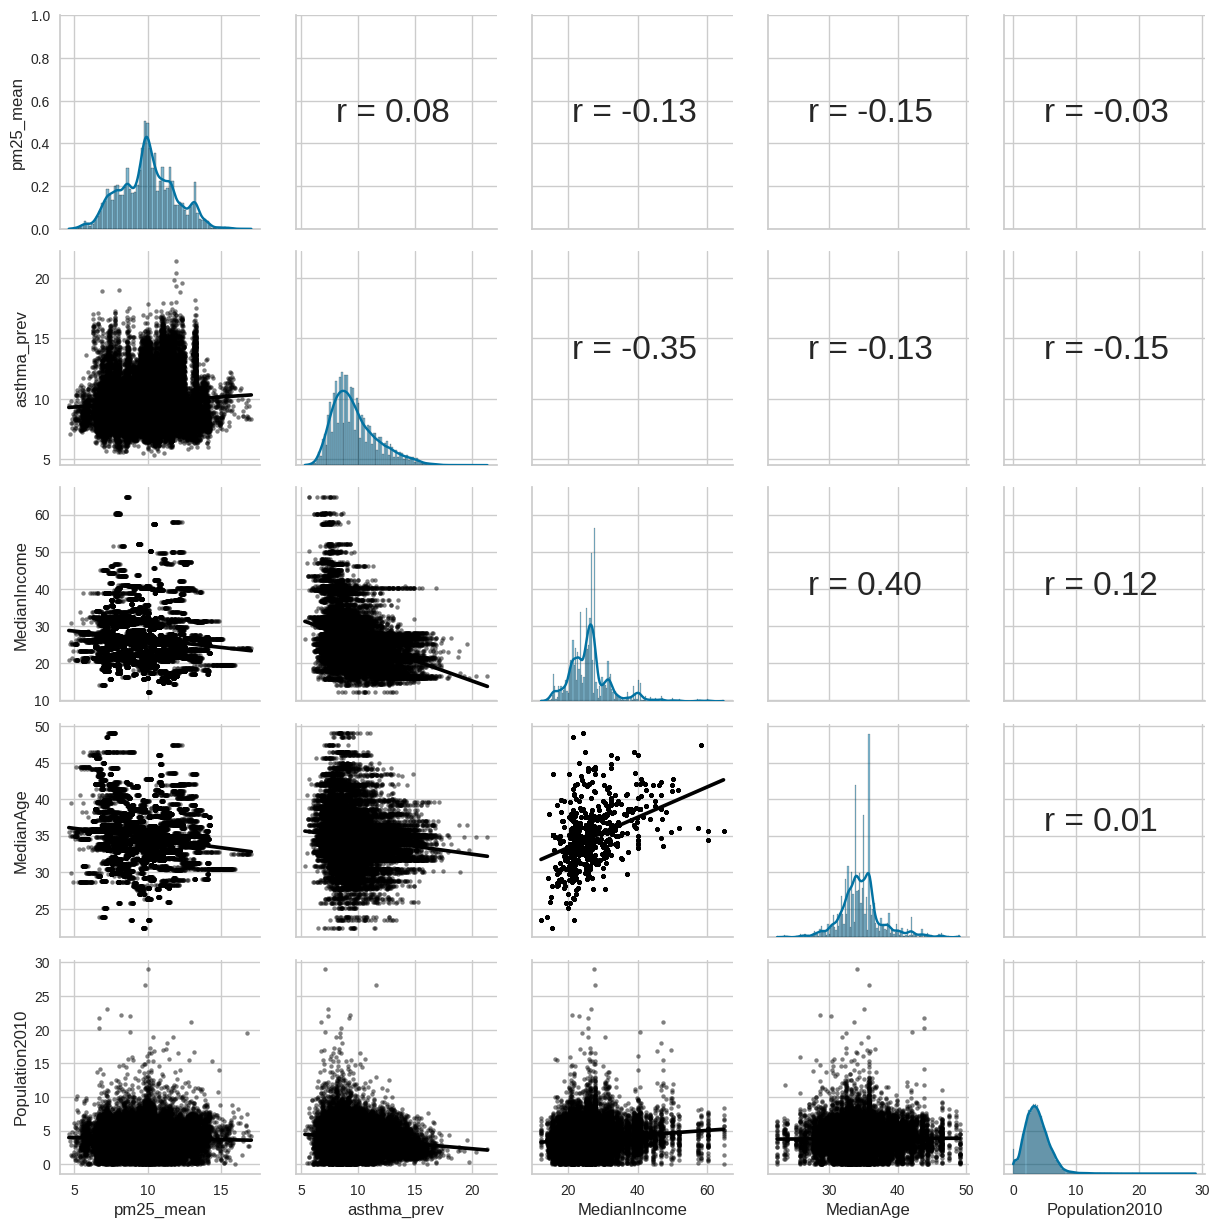

In [51]:

plt.figure(figsize=(12,12))
g = sns.PairGrid(pm_asthma_data[['pm25_mean', 'asthma_prev', 'MedianIncome', 'MedianAge', 'Population2010']])

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.2, .5), size=24, xycoords=ax.transAxes)

g.map_upper(corrfunc)
g.map_lower(sns.regplot, color='black', scatter_kws={'s': 10, 'alpha':.5})
g.map_diag(sns.histplot, kde=True, legend=False)
plt.show()


standard linear regression model

In [52]:
lm_asthma_pm = smf.ols('asthma_prev ~ pm25_mean + MedianIncome +  MedianAge + Population2010', data=pm_asthma_data).fit()
print(lm_asthma_pm.summary())

                            OLS Regression Results                            
Dep. Variable:            asthma_prev   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     1061.
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:19:16   Log-Likelihood:                -54500.
No. Observations:               26681   AIC:                         1.090e+05
Df Residuals:                   26676   BIC:                         1.091e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.5516      0.150     83.

### Figure 17.11

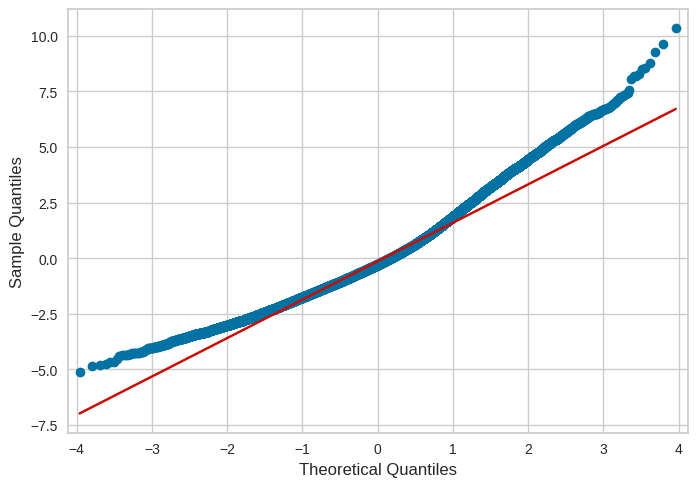

In [53]:
model_data = pd.DataFrame({'resid': lm_asthma_pm.resid}, index=pm_asthma_data.index)
fig = sm.qqplot(model_data.resid, line="q")

### Figure 17.12

In [54]:
# first fit linear mixed effects model

lme = smf.mixedlm("asthma_prev ~ pm25_mean + MedianAge + MedianIncome + Population2010", 
                  pm_asthma_data, groups=pm_asthma_data["city"],
                re_formula="~pm25_mean").fit(method=["lbfgs"])
print(lme.summary())


              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   asthma_prev
No. Observations:     26681     Method:               REML       
No. Groups:           494       Scale:                1.9514     
Min. group size:      8         Log-Likelihood:       -48031.9272
Max. group size:      2110      Converged:            Yes        
Mean group size:      54.0                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               6.977    1.146  6.087 0.000  4.730  9.223
pm25_mean               0.360    0.074  4.856 0.000  0.215  0.506
MedianAge               0.050    0.028  1.754 0.079 -0.006  0.105
MedianIncome           -0.103    0.014 -7.125 0.000 -0.132 -0.075
Population2010         -0.027    0.005 -5.652 0.000 -0.037 -0.018
Group Var             15

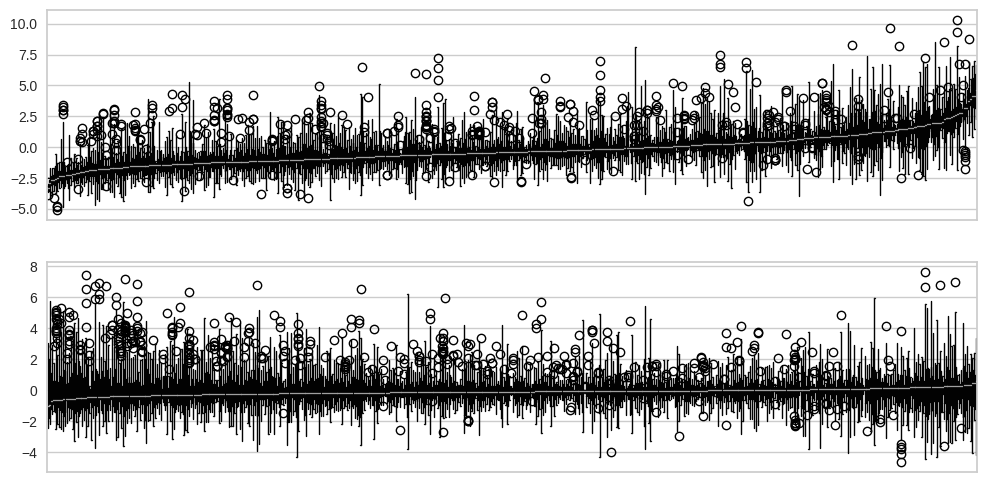

In [55]:
model_data['city'] = pm_asthma_data.city
model_data['resid_lme'] = lme.resid

def boxplot_sorted(df, by, column, ax):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    plot = df2[meds.index].boxplot(rot=90, ax=ax)
    plot.get_xaxis().set_ticks([])

fig, ax = plt.subplots(2, 1, figsize=(12,6))

boxplot_sorted(model_data, 'city', 'resid', ax=ax[0])

boxplot_sorted(model_data, 'city', 'resid_lme', ax=ax[1])


R mixed effect model result for comparison

In [56]:
%%R
library(lme4)
lmer_asthma_pm = lmer(asthma_prev ~ pm25_mean + MedianAge + MedianIncome + Population2010 + (1 + pm25_mean|city),
                    data=pm_asthma_data,
                     control = lmerControl(
                           optimizer ='optimx', optCtrl=list(method='nlminb')))
print(summary(lmer_asthma_pm))

R[write to console]: Loading required namespace: optimx



Linear mixed model fit by REML ['lmerMod']
Formula: asthma_prev ~ pm25_mean + MedianAge + MedianIncome + Population2010 +  
    (1 + pm25_mean | city)
   Data: pm_asthma_data
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 96063.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3329 -0.6246 -0.0829  0.5462  5.4814 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 city     (Intercept) 158.898  12.605        
          pm25_mean     1.457   1.207   -0.99
 Residual               1.951   1.397        
Number of obs: 26681, groups:  city, 494

Fixed effects:
                Estimate Std. Error t value
(Intercept)     6.976828   1.122358   6.216
pm25_mean       0.360445   0.071826   5.018
MedianAge       0.049659   0.028236   1.759
MedianIncome   -0.103198   0.014298  -7.217
Population2010 -0.027124   0.004796  -5.655

Correlation of Fixed Effects:
            (Intr) pm25_m MednAg MdnInc
pm25_mean   

### Table 17.4

In [57]:
lme_ci = pd.DataFrame(lme.params, columns=['estimate'])
lme_ci = lme_ci.join(lme.conf_int().rename(columns={0: '2.5%', 1:'97.5%'})).iloc[1:5,:]
lme_ci

,estimate,2.5%,97.5%
pm25_mean,0.360453,0.214966,0.505941
MedianAge,0.049660,-0.005829,0.105149
MedianIncome,-0.103198,-0.131586,-0.074811
Population2010,-0.027124,-0.036531,-0.017718


## Example 4: Response of plants to nitrogen fertilizers and soil tilling

#### 3. Prepare and visualize the data

In [58]:
fert_data_all = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/fertilizer/Fertsyntraitsall_Jan27_2008.txt', delimiter='\t')
fert_data_all = fert_data_all.query('Rawabundmetric == "Grams biomass" and Site == "KBS"')
fert_data_all['plotID_common'] = fert_data_all.plotID = fert_data_all.Fert
fert_data_all['log_rawabund'] = scale(np.log(fert_data_all.Rawabund))

fert_data_all.shape

(2615, 27)

### Figure 17.13

Text(0.5, 0, 'Raw crop abundance')

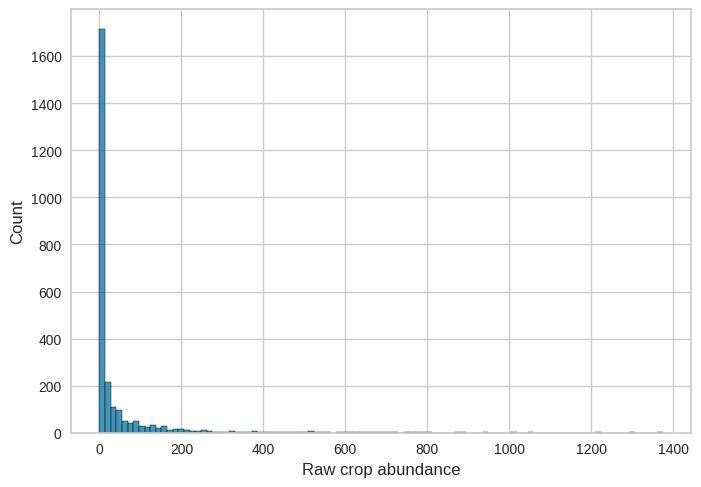

In [59]:
sns.histplot(fert_data_all.Rawabund, bins=100)
plt.xlabel('Raw crop abundance')

Simple linear model output:

In [60]:
lm_result_fert = smf.ols('Rawabund ~ Fert*Experiment + Year', data=fert_data_all).fit()
print(lm_result_fert.summary())

                            OLS Regression Results                            
Dep. Variable:               Rawabund   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     20.52
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           1.16e-16
Time:                        15:19:47   Log-Likelihood:                -16314.
No. Observations:                2615   AIC:                         3.264e+04
Df Residuals:                    2610   BIC:                         3.267e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### Figure 17.14

This figure involves fitting a linear mixed model with multiple random slopes.  This is in theory possible using statsmodels, but it is not well documented.  Instead, we will simply use the R bridge to run lmer on our data.

In [61]:
fert_data_clean = fert_data_all[['log_rawabund', 'Fert', 'Experiment', 'Year', 'plotID_common', 'Species_code']]

In [62]:
%%R -i fert_data_clean

lm.result_fert = lm(log_rawabund ~ Fert*Experiment + Year , 
                        data=fert_data_clean)

lmer.result_fert = lmer(log_rawabund ~ Fert*Experiment + Year + (1 + Fert|plotID_common) + (1 + Fert|Species_code) , 
                        data=fert_data_clean)


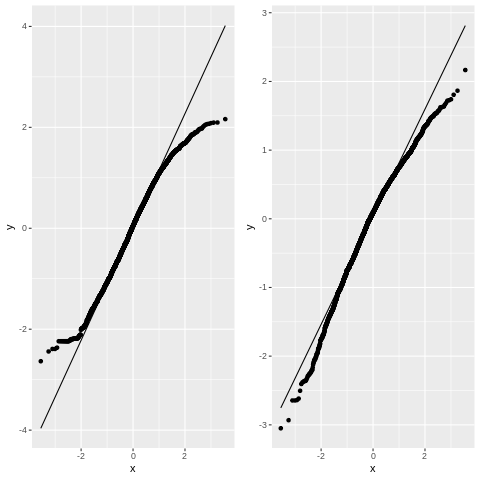

In [63]:
%%R 

library(cowplot)
library(broom)
model.data = augment(lm.result_fert) %>%
  mutate(plotID_common = fert_data_clean$plotID_common,
         Species_code = fert_data_clean$Species_code)

p1 = ggplot(model.data, aes(sample=.resid)) + geom_qq() + geom_qq_line()

lmer.result_fert = lmer(log_rawabund ~ Fert*Experiment + Year + (1 + Fert|plotID_common) + (1 + Fert|Species_code),
                        data=fert_data_clean)

fert_data = fert_data_clean %>%
  mutate(lmer_resid = resid(lmer.result_fert))

p2 = ggplot(fert_data, aes(sample=lmer_resid)) + geom_qq() + geom_qq_line()
plot_grid(p1, p2)

### Figure 17.15

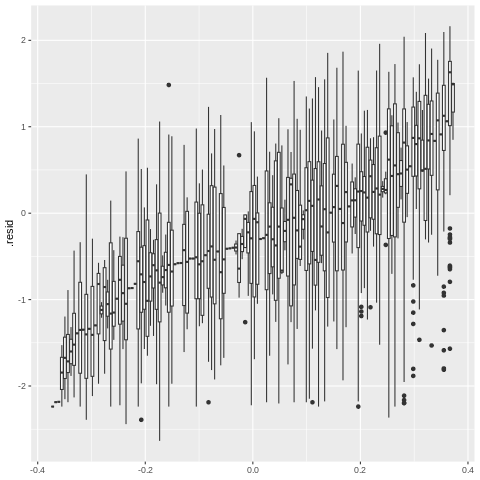

In [64]:
%%R

model_means_sorted = model.data %>% group_by(Species_code) %>%
  summarize_all(mean) %>%
  arrange(.resid)
ggplot(model.data, aes(y=.resid, group=factor(Species_code, levels=model_means_sorted$Species_code))) + geom_boxplot()

Linear mixed effects model output:

In [65]:
%%R

print(summary(lmer.result_fert))

Linear mixed model fit by REML ['lmerMod']
Formula: 
log_rawabund ~ Fert * Experiment + Year + (1 + Fert | plotID_common) +  
    (1 + Fert | Species_code)
   Data: fert_data_clean

REML criterion at convergence: 6476.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8583 -0.6309  0.1140  0.7059  2.7394 

Random effects:
 Groups        Name        Variance Std.Dev. Corr
 Species_code  (Intercept) 0.32074  0.5663       
               Fert        0.07087  0.2662   0.01
 plotID_common (Intercept) 0.64447  0.8028       
               Fert        0.48111  0.6936   0.31
 Residual                  0.62516  0.7907       
Number of obs: 2615, groups:  Species_code, 132; plotID_common, 2

Fixed effects:
                         Estimate Std. Error t value
(Intercept)             13.420304  11.377770   1.180
Fert                     0.279636   1.454441   0.192
ExperimentUntilled       0.384860   0.057878   6.649
Year                    -0.006994   0.005681  -1.231
Fert:Experimen

Effect sizes

In [66]:
%%R

library(emmeans)
emm = emmeans(lmer.result_fert, pairwise ~ Fert*Experiment)
print(contrast(emm, 'tukey'))

 contrast                        estimate     SE       df t.ratio p.value
 Fert0 Tilled - Fert1 Tilled      -0.2796 1.4545 15559535  -0.192  0.9975
 Fert0 Tilled - Fert0 Untilled    -0.3849 0.0583     1183  -6.597  <.0001
 Fert0 Tilled - Fert1 Untilled    -0.3312 1.4542 41417709  -0.228  0.9958
 Fert1 Tilled - Fert0 Untilled    -0.1052 1.4547 29073394  -0.072  0.9999
 Fert1 Tilled - Fert1 Untilled    -0.0516 0.0722      759  -0.714  0.8914
 Fert0 Untilled - Fert1 Untilled   0.0537 1.4539 38437869   0.037  1.0000

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 
